## Data Cleaning and Processing

In [2]:
import json
import re
import numpy as np
import pandas as pd
import glob

def convert_to_minutes(layover):
    if layover:
        hours = 0
        minutes = 0
        if 'h' in layover:
            hours = int(re.search(r'(\d+)h', layover).group(1))
        if 'm' in layover:
            minutes = int(re.search(r'(\d+)m', layover).group(1))
        return hours * 60 + minutes
    return np.nan

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
# "Jun",
directions = ["SA_YVN", "YVN_SA"]
ranges = ["_one_week_", "_two_week_", "_1_month_"]

dataframes = []

for direction in directions:
    for month in months:
        for rang in ranges:
            with open(f'{month}{rang}{direction}.json', 'r') as file:
                data = json.load(file)

            # Initialize columns
            data['stop1'] = []
            data['stop1_layover'] = []
            data['stop2'] = []
            data['stop2_layover'] = []
            data['stop3'] = []
            data['stop3_layover'] = []
            data['ret_stop1'] = []
            data['ret_stop1_layover'] = []
            data['ret_stop2'] = []
            data['ret_stop2_layover'] = []
            data['ret_stop3'] = []
            data['ret_stop3_layover'] = []
            data['month'] = [month] * len(data.get("layover_titles", []))
            data['range'] = [rang] * len(data.get("layover_titles", []))

            # Process layover titles
            for layover in data.get("layover_titles", []):
                stops = []
                layovers = []
                for item in layover:
                    if item:
                        match = re.match(r'(\d+h \d+m layover|(\d+h|[1-9]h|[1-9]m) layover), <b>(.*?)</b>', item)
                        if match:
                            layovers.append(match.group(1))
                            stops.append(match.group(3))
                
                # Append values to the corresponding lists
                data['stop1'].append(stops[0] if len(stops) > 0 else np.nan)
                data['stop1_layover'].append(convert_to_minutes(layovers[0]) if len(layovers) > 0 else np.nan)
                data['stop2'].append(stops[1] if len(stops) > 1 else np.nan)
                data['stop2_layover'].append(convert_to_minutes(layovers[1]) if len(layovers) > 1 else np.nan)
                data['stop3'].append(stops[2] if len(stops) > 2 else np.nan)
                data['stop3_layover'].append(convert_to_minutes(layovers[2]) if len(layovers) > 2 else np.nan)

            # Process return layover titles
            for layover in data.get("ret_layover_titles", []):
                stops = []
                layovers = []
                for item in layover:
                    if item:
                        match = re.match(r'(\d+h \d+m layover|(\d+h|[1-9]h|[1-9]m) layover), <b>(.*?)</b>', item)
                        if match:
                            layovers.append(match.group(1))
                            stops.append(match.group(3))
                
                # Append values to the corresponding lists
                data['ret_stop1'].append(stops[0] if len(stops) > 0 else np.nan)
                data['ret_stop1_layover'].append(convert_to_minutes(layovers[0]) if len(layovers) > 0 else np.nan)
                data['ret_stop2'].append(stops[1] if len(stops) > 1 else np.nan)
                data['ret_stop2_layover'].append(convert_to_minutes(layovers[1]) if len(layovers) > 1 else np.nan)
                data['ret_stop3'].append(stops[2] if len(stops) > 2 else np.nan)
                data['ret_stop3_layover'].append(convert_to_minutes(layovers[2]) if len(layovers) > 2 else np.nan)

            # Remove original layover titles
            data.pop('layover_titles', None)
            data.pop('ret_layover_titles', None)

            # Create a DataFrame from the processed data
            dynamic_df = pd.DataFrame(data)

            # Append the DataFrame to the list
            dataframes.append(dynamic_df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

In [3]:
def get_season(month):
    if month in ["Dec","Jan", "Feb"]:
        return 'Winter'
    elif month in ["Mar", "Apr", "May"]:
        return 'Spring'
    elif month in ["Jun", "Jul", "Aug"]:
        return 'Summer'
    elif month in ["Sep", "Oct", "Nov"]:
        return 'Autumn'

In [4]:
pd.set_option('display.max_columns', None)
df.drop_duplicates(keep='first', inplace=True)

In [5]:
# Assuming convert_to_minutes is defined properly and returns numeric values
df["duration"] = df["duration"].apply(convert_to_minutes).astype(int)
df["ret_duration"] = df["ret_duration"].apply(convert_to_minutes).astype(int)

In [6]:
# Fill NaN values with 0 (or any integer of your choice)
df["stop1_layover"] = df["stop1_layover"].fillna(0).astype(int)
df["stop2_layover"] = df["stop2_layover"].fillna(0).astype(int)
df["stop3_layover"] = df["stop3_layover"].fillna(0).astype(int)
df["ret_stop1_layover"] = df["ret_stop1_layover"].fillna(0).astype(int)
df["ret_stop2_layover"] = df["ret_stop2_layover"].fillna(0).astype(int)
df["ret_stop3_layover"] = df["ret_stop3_layover"].fillna(0).astype(int)
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(int)
df['cabin'] = df['price'].apply(lambda x: 'Business' if x > 1700 else 'Economy')

In [7]:
df.rename(columns={'range': 'week'}, inplace=True)
df['week'] = df['week'].replace({'_one_week_': 'One Week', '_two_week_': 'Two week', '_1_month_': 'One Month'})
df['season'] = df['month'].apply(get_season)
df['route'] = df['departure'] + ' ' + df['arrival']

In [8]:
df["stops"] = df[['stop1','stop2', 'stop3']].notna().sum(axis = 1)
df["ret_stops"] = df[['ret_stop1','ret_stop2', 'ret_stop3']].notna().sum(axis = 1)
df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)

*Clean data loading into csv*

In [9]:
df.to_csv("Flight_prices.csv",index = False)

## Data Exploration

In [10]:
print("Departure: " ,df["departure"].unique())
print("Arrival: " ,df["arrival"].unique())

Departure:  ['DMM' 'RUH' 'JED' 'EVN']
Arrival:  ['EVN' 'MED' 'RUH' 'JED']


In [11]:
for i in df.columns:
    print(df[i].value_counts(), end = "\n\n" + "-"*40 + "\n\n")

carrier
Emirates              7901
flydubai              5039
Multiple Airlines     3702
Qatar Airways         3627
Lufthansa             2060
Air Arabia             565
Pegasus Airlines       161
Wizz Air Abu Dhabi      90
Wizz Air Malta          90
Aegean Airlines          1
Name: count, dtype: int64

----------------------------------------

departure
EVN    10420
DMM     4690
RUH     4227
JED     3899
Name: count, dtype: int64

----------------------------------------

arrival
EVN    12816
RUH     4359
JED     3933
MED     2128
Name: count, dtype: int64

----------------------------------------

duration
1495    725
1620    640
970     542
1280    424
1135    399
       ... 
1865      1
2620      1
2020      1
1065      1
1060      1
Name: count, Length: 283, dtype: int64

----------------------------------------

departure_time
12:20 pm    2302
12:35 pm    1410
3:30 am     1385
1:55 am     1074
2:45 am      983
            ... 
6:25 pm        1
12:15 pm       1
12:40 pm       1
3:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23236 entries, 0 to 23248
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   carrier             23236 non-null  object  
 1   departure           23236 non-null  object  
 2   arrival             23236 non-null  object  
 3   duration            23236 non-null  int64   
 4   departure_time      23236 non-null  object  
 5   arrival_time        23236 non-null  object  
 6   ret_carrier         23236 non-null  object  
 7   ret_departure       23236 non-null  object  
 8   ret_arrival         23236 non-null  object  
 9   ret_duration        23236 non-null  int64   
 10  ret_departure_time  23236 non-null  object  
 11  ret_arrival_time    23236 non-null  object  
 12  price               23236 non-null  int64   
 13  stop1               23236 non-null  object  
 14  stop1_layover       23236 non-null  int64   
 15  stop2               4727 non-null   objec

In [13]:
df.shape

(23236, 32)

In [14]:
df.count()

carrier               23236
departure             23236
arrival               23236
duration              23236
departure_time        23236
arrival_time          23236
ret_carrier           23236
ret_departure         23236
ret_arrival           23236
ret_duration          23236
ret_departure_time    23236
ret_arrival_time      23236
price                 23236
stop1                 23236
stop1_layover         23236
stop2                  4727
stop2_layover         23236
stop3                   568
stop3_layover         23236
ret_stop1             23219
ret_stop1_layover     23236
ret_stop2              3744
ret_stop2_layover     23236
ret_stop3                11
ret_stop3_layover     23236
month                 23236
week                  23236
cabin                 23236
season                23236
route                 23236
stops                 23236
ret_stops             23236
dtype: int64

In [15]:
df.describe()

,duration,ret_duration,price,stop1_layover,stop2_layover,stop3_layover,ret_stop1_layover,ret_stop2_layover,ret_stop3_layover,stops,ret_stops
count,23236.000000,23236.000000,23236.000000,23236.000000,23236.000000,23236.000000,23236.000000,23236.000000,23236.000000,23236.000000,23236.000000
mean,1121.336805,1090.524230,1070.114004,671.683164,68.009124,10.973274,672.742124,46.899897,0.137502,1.227879,1.160871
std,416.756090,417.997841,494.348488,438.933218,163.302202,75.164167,436.908782,133.374414,6.879440,0.474183,0.370685
min,360.000000,320.000000,265.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,780.000000,760.000000,723.000000,280.000000,0.000000,0.000000,270.000000,0.000000,0.000000,1.000000,1.000000
50%,1115.000000,1080.000000,1029.000000,600.000000,0.000000,0.000000,605.000000,0.000000,0.000000,1.000000,1.000000
75%,1480.000000,1445.000000,1255.000000,1000.000000,0.000000,0.000000,985.000000,0.000000,0.000000,1.000000,1.000000
max,2980.000000,2520.000000,4248.000000,2200.000000,1070.000000,710.000000,2025.000000,1340.000000,385.000000,3.000000,3.000000


In [16]:
df.isna().sum()

carrier                   0
departure                 0
arrival                   0
duration                  0
departure_time            0
arrival_time              0
ret_carrier               0
ret_departure             0
ret_arrival               0
ret_duration              0
ret_departure_time        0
ret_arrival_time          0
price                     0
stop1                     0
stop1_layover             0
stop2                 18509
stop2_layover             0
stop3                 22668
stop3_layover             0
ret_stop1                17
ret_stop1_layover         0
ret_stop2             19492
ret_stop2_layover         0
ret_stop3             23225
ret_stop3_layover         0
month                     0
week                      0
cabin                     0
season                    0
route                     0
stops                     0
ret_stops                 0
dtype: int64

In [55]:
df.head()

,carrier,departure,arrival,duration,departure_time,arrival_time,ret_carrier,ret_departure,ret_arrival,ret_duration,ret_departure_time,ret_arrival_time,price,stop1,stop1_layover,stop2,stop2_layover,stop3,stop3_layover,ret_stop1,ret_stop1_layover,ret_stop2,ret_stop2_layover,ret_stop3,ret_stop3_layover,month,week,cabin,season,route,stops,ret_stops
0,flydubai,DMM,EVN,475,8:25 pm,5:20 am,flydubai,EVN,DMM,360,6:20 am,11:20 am,593,Dubai Intl,180,NaN,0,NaN,0,Dubai Intl,75,NaN,0,NaN,0,Jan,One Week,Economy,Winter,DMM EVN,1,1
1,flydubai,DMM,EVN,475,8:25 pm,5:20 am,flydubai,EVN,DMM,1230,12:35 pm,8:05 am,472,Dubai Intl,180,NaN,0,NaN,0,Dubai Intl,945,NaN,0,NaN,0,Jan,One Week,Economy,Winter,DMM EVN,1,1
2,flydubai,DMM,EVN,490,12:20 pm,9:30 pm,flydubai,EVN,DMM,360,6:20 am,11:20 am,669,Dubai Intl,200,NaN,0,NaN,0,Dubai Intl,75,NaN,0,NaN,0,Jan,One Week,Economy,Winter,DMM EVN,1,1
3,flydubai,DMM,EVN,475,8:25 pm,5:20 am,flydubai,EVN,DMM,470,12:35 pm,7:25 pm,551,Dubai Intl,180,NaN,0,NaN,0,Dubai Intl,185,NaN,0,NaN,0,Jan,One Week,Economy,Winter,DMM EVN,1,1
4,flydubai,DMM,EVN,490,12:20 pm,9:30 pm,flydubai,EVN,DMM,470,12:35 pm,7:25 pm,562,Dubai Intl,200,NaN,0,NaN,0,Dubai Intl,185,NaN,0,NaN,0,Jan,One Week,Economy,Winter,DMM EVN,1,1


# Exploratory Data Analysis

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

def format_func(value, tick_number):
    return f'${int(value)}'
    
def format_hour(value, tick_number):
    hours = int(value // 60)
    minutes = int(value % 60)
    return f"{hours}h {minutes:01d}m"

### 1. Which routes are the most cost-effective?

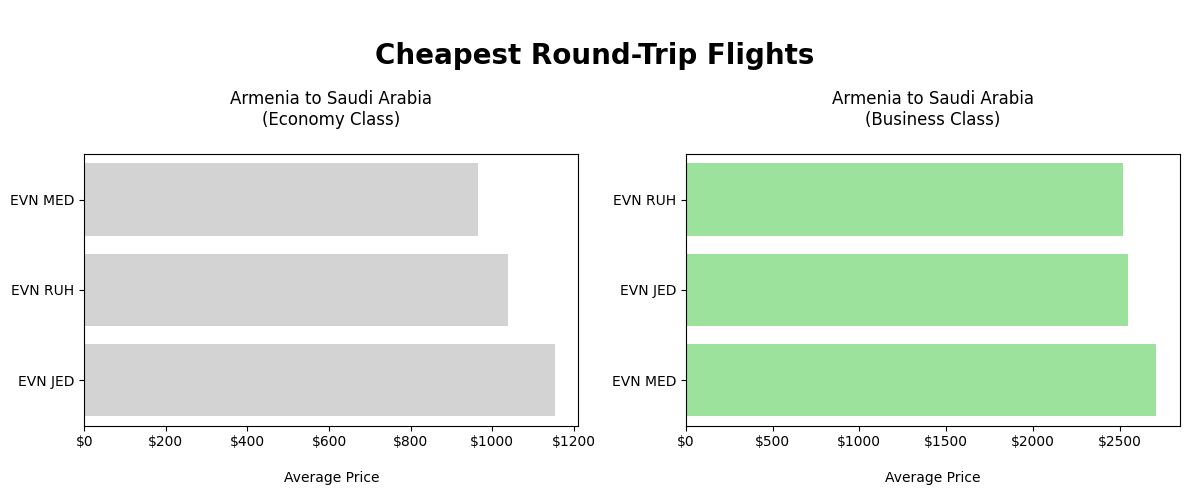

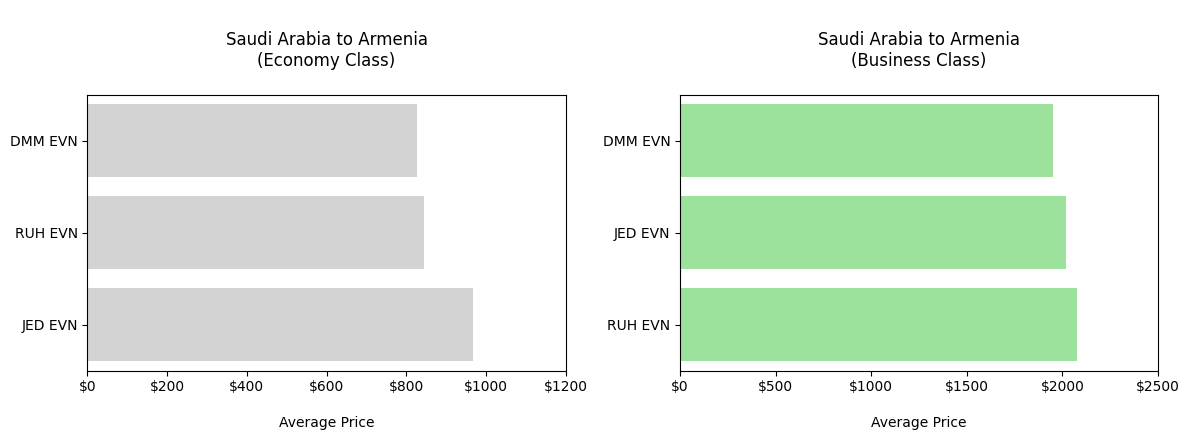

In [23]:
# Group by route and calculate the mean price
arm_sa_econom = df[(df["departure"] == "EVN") & (df["cabin"] == "Economy")].groupby('route')['price'].mean().reset_index()
sa_arm_econom = df[(df["departure"] != "EVN") & (df["cabin"] == "Economy")].groupby('route')['price'].mean().reset_index()
arm_sa_business = df[(df["departure"] == "EVN") & (df["cabin"] != "Economy")].groupby('route')['price'].mean().reset_index()
sa_arm_business = df[(df["departure"] != "EVN") & (df["cabin"] != "Economy")].groupby('route')['price'].mean().reset_index()

# Sort by price in ascending order to find the most cost-effective routes
arm_sa_econom = arm_sa_econom.sort_values(by = 'price')
sa_arm_econom = sa_arm_econom.sort_values(by = 'price')
arm_sa_business = arm_sa_business.sort_values(by = 'price')
sa_arm_business = sa_arm_business.sort_values(by = 'price')

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the data for Armenia to Saudi Arabia
sns.barplot(x='price', y='route', data=arm_sa_econom, color = 'lightgrey', ax=axes[0])
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
axes[0].set_title('Armenia to Saudi Arabia\n(Economy Class)\n')
axes[0].set_xlabel('\nAverage Price')
axes[0].set_ylabel('')


sns.barplot(x='price', y='route', data=arm_sa_business, color = 'lightgreen', ax=axes[1])
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
axes[1].set_title('Armenia to Saudi Arabia\n(Business Class)\n')
axes[1].set_xlabel('\nAverage Price')
axes[1].set_ylabel('')

fig.suptitle("\nCheapest Round-Trip Flights",fontweight='bold', fontsize = 20)
plt.tight_layout()
plt.show()

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

sns.barplot(x='price', y='route', data=sa_arm_econom, color = 'lightgrey', ax=axes[0])
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
axes[0].set_title('\nSaudi Arabia to Armenia\n(Economy Class)\n')
axes[0].set_xlabel('\nAverage Price')
axes[0].set_xticks(range(0, 1201, 200))
axes[0].set_ylabel('')


sns.barplot(x='price', y='route', data=sa_arm_business, color = 'lightgreen', ax=axes[1])
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
axes[1].set_title('\nSaudi Arabia to Armenia\n(Business Class)\n')
axes[1].set_xlabel('\nAverage Price')
axes[1].set_xticks(range(0, 2501, 500))
axes[1].set_ylabel('')


plt.tight_layout()
plt.show()


In [24]:
arm_econom = df[(df["departure"] == "EVN") & (df["cabin"] == "Economy")]
sa_econom = df[(df["departure"] != "EVN") & (df["cabin"] == "Economy")]
arm_business = df[(df["departure"] == "EVN") & (df["cabin"] != "Economy")]
sa_business = df[(df["departure"] != "EVN") & (df["cabin"] != "Economy")]

### 2. Which routes have the shortest travel times?

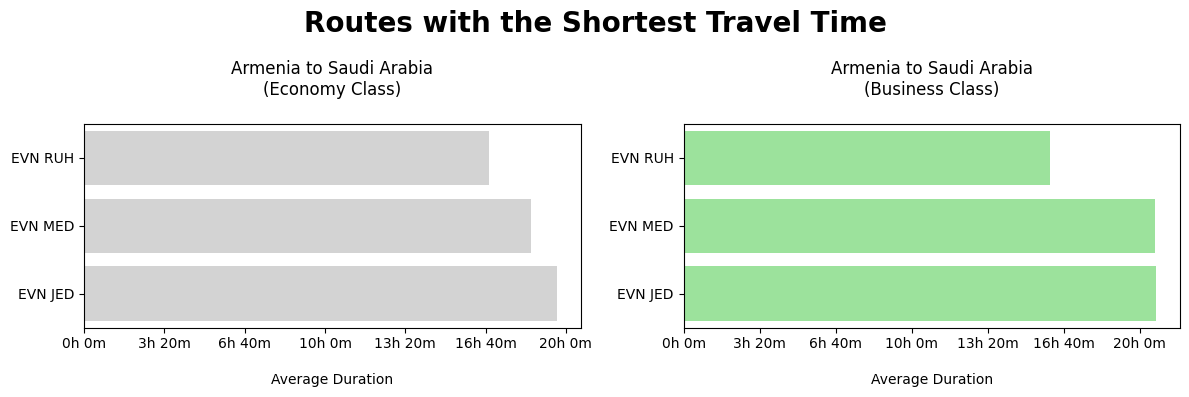

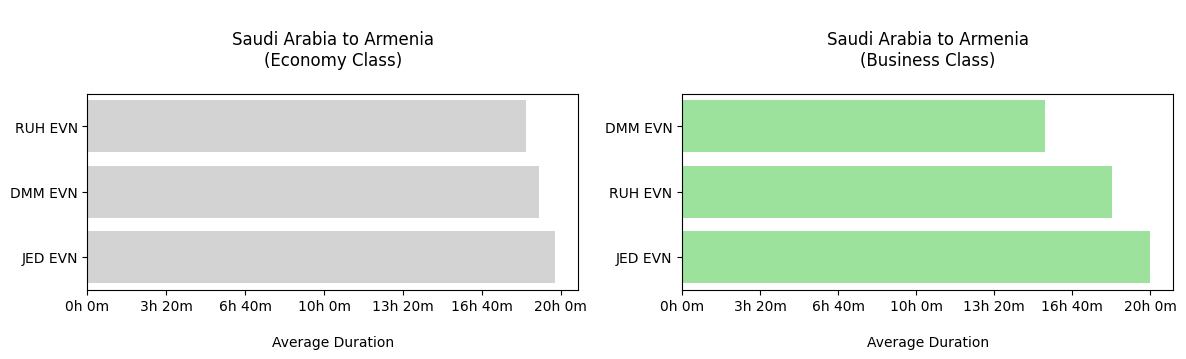

In [25]:
a1 = arm_econom.groupby('route')['duration'].mean().reset_index()
b1 = sa_econom.groupby('route')['duration'].mean().reset_index()
a2 = arm_business.groupby('route')['duration'].mean().reset_index()
b2 = sa_business.groupby('route')['duration'].mean().reset_index()


# Sort by duration in ascending order
a1 = a1.sort_values(by='duration')
a2 = a2.sort_values(by='duration')
b1 = b1.sort_values(by='duration')
b2 = b2.sort_values(by='duration')


# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plotting the data for Armenia to Saudi Arabia
sns.barplot(x='duration', y='route', data=a1, color = 'lightgrey', ax=axes[0])

axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(format_hour))
axes[0].set_title('Armenia to Saudi Arabia\n(Economy Class)\n')
axes[0].set_xlabel('\nAverage Duration')
axes[0].set_ylabel('')


sns.barplot(x='duration', y='route', data=a2, color = 'lightgreen', ax=axes[1])
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(format_hour))
axes[1].set_title('Armenia to Saudi Arabia\n(Business Class)\n')
axes[1].set_xlabel('\nAverage Duration')
axes[1].set_ylabel('')

fig.suptitle("Routes with the Shortest Travel Time", fontweight='bold',fontsize = 20)
plt.tight_layout()
plt.show()

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 3.7))

sns.barplot(x='duration', y='route', data=b1, color = 'lightgrey', ax=axes[0])
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(format_hour))
axes[0].set_title('\nSaudi Arabia to Armenia\n(Economy Class)\n')
axes[0].set_xlabel('\nAverage Duration')
axes[0].set_ylabel('')


sns.barplot(x='duration', y='route', data=b2, color = 'lightgreen', ax=axes[1])
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(format_hour))
axes[1].set_title('\nSaudi Arabia to Armenia\n(Business Class)\n')
axes[1].set_xlabel('\nAverage Duration')
axes[1].set_ylabel('')


plt.tight_layout()
plt.show()

### 3. How do layovers impact overall travel time and price?

In [26]:
business = pd.concat([arm_business,sa_business], axis=0)
econom = pd.concat([arm_econom,sa_econom], axis=0)

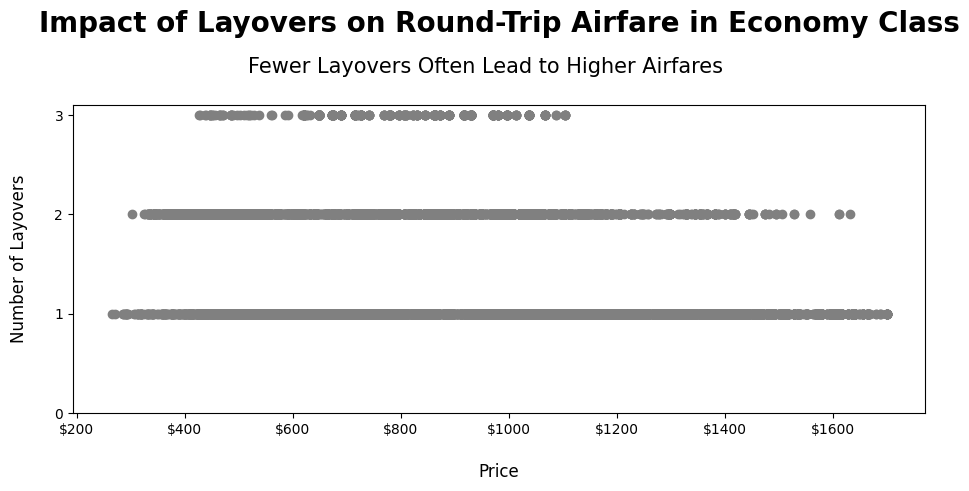

In [27]:
plt.figure(figsize=(11,4))
plt.scatter(x='price', y='stops', data=econom, color = "gray")
plt.title('Impact of Layovers on Round-Trip Airfare in Economy Class\n\n', fontsize=20, fontweight="bold")
plt.suptitle('Fewer Layovers Often Lead to Higher Airfares', fontsize=15, y=1)
plt.xlabel('\nPrice',fontsize = 12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.ylabel('Number of Layovers\n',fontsize = 12)
plt.yticks(range(0, 4, 1))
plt.show()

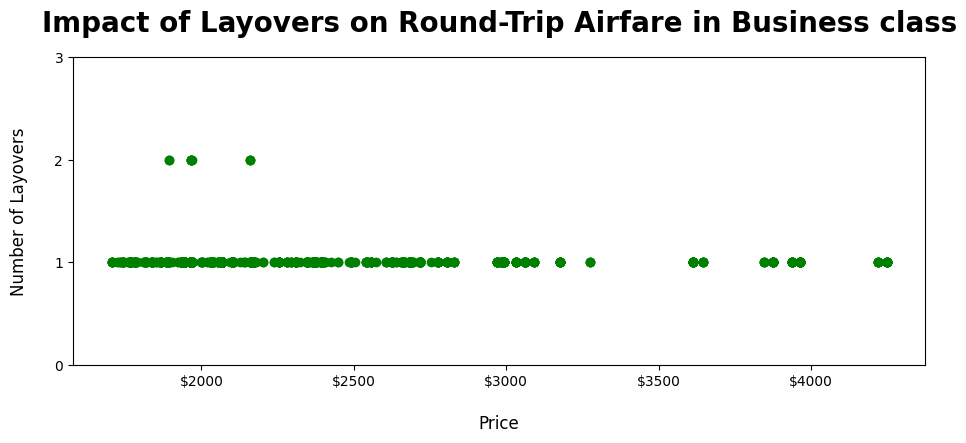

In [28]:
plt.figure(figsize=(11,4))
plt.scatter(x='price', y='stops', data=business ,color = "green")
plt.title('Impact of Layovers on Round-Trip Airfare in Business class\n', fontsize=20, fontweight="bold",y = 0.95)
# plt.suptitle('    (The fewer the layovers, the higher the airfare)', fontsize=15, y=1)
plt.xlabel('\nPrice',fontsize = 12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.ylabel('Number of Layovers\n',fontsize = 12)
plt.yticks(range(0, 4, 1))
plt.show()

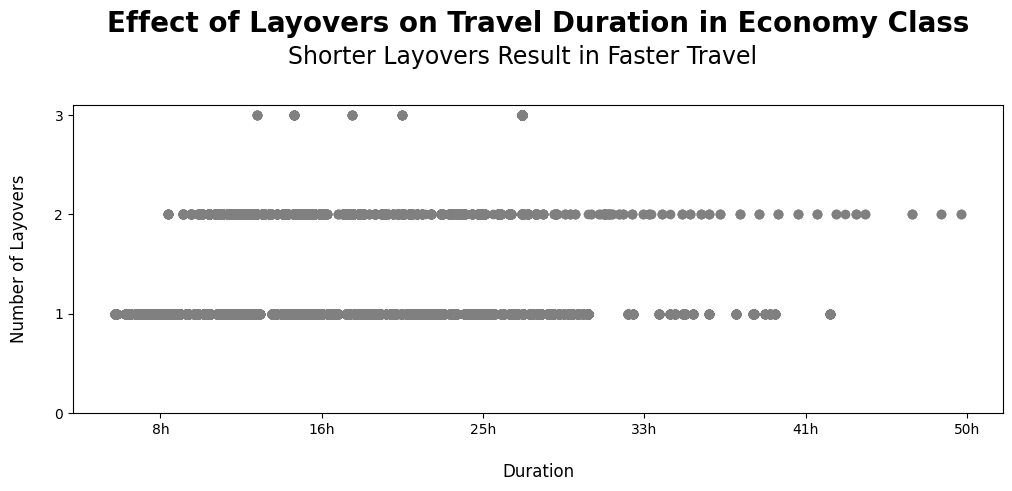

In [29]:
plt.figure(figsize=(12,4))
plt.scatter(y='stops', x='duration', data=econom,color = "gray")
plt.title('Effect of Layovers on Travel Duration in Economy Class\n\n', fontsize=20, fontweight="bold")
plt.suptitle('Shorter Layovers Result in Faster Travel\n', fontsize=17, y=1.03)
plt.ylabel('Number of Layovers\n',fontsize = 12)
plt.yticks(range(0, 4, 1))
plt.xlabel('\nDuration',fontsize = 12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x // 60)}h"))
plt.show()

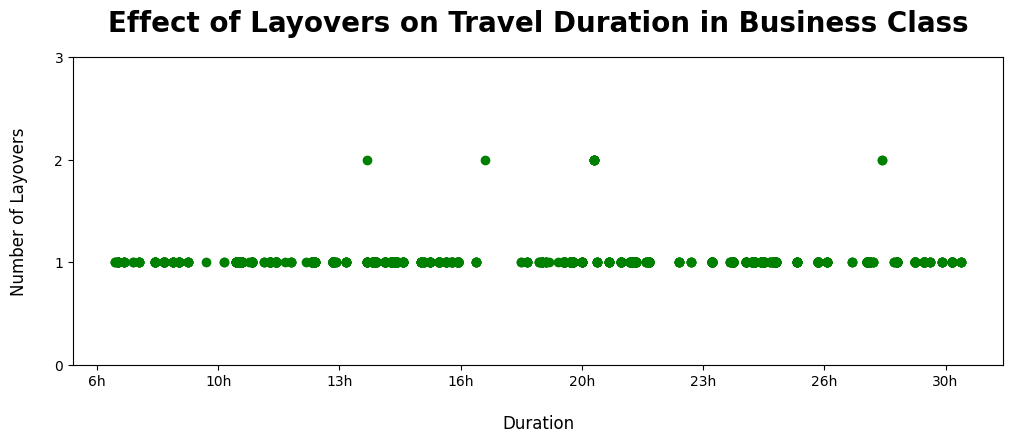

In [30]:
plt.figure(figsize=(12,4))
plt.scatter(y='stops', x='duration', data=business,color = "green")
plt.title('Effect of Layovers on Travel Duration in Business Class\n', fontsize=20, fontweight="bold",y = 0.95)
# plt.suptitle('Shorter Layovers Result in Faster Travel\n', fontsize=17, y=1.03)
plt.ylabel('Number of Layovers\n',fontsize = 12)
plt.yticks(range(0, 4, 1))
plt.xlabel('\nDuration',fontsize = 12)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x // 60)}h"))
plt.show()

In [31]:
def average_stop_duration(df):
    avg_duration = pd.DataFrame()
    for stop in ['stop1_layover', 'stop2_layover', 'stop3_layover', 'duration']:
        avg = df[df[stop] != 0]  # Exclude rows where stop is 0
        avg = avg.groupby('cabin')[stop].mean().reset_index()
        avg.columns = ['cabin', f'average_{stop}']
        avg_duration = pd.merge(avg_duration, avg, on='cabin', how='outer') if not avg_duration.empty else avg
    for stop in ['stop1_layover', 'stop2_layover', 'stop3_layover', 'duration']:
        avg_duration[f'average_{stop}'] = avg_duration[f'average_{stop}'].fillna(0) / 60  # Convert to hours
        avg_duration[f'average_{stop}'] = avg_duration[f'average_{stop}'].apply(
            lambda x: f"{int(x)}h {int((x - int(x)) * 60)}m" if x > 0 else "0h 0m"  # Format as hours and minutes
        )
    return avg_duration
average_durations = average_stop_duration(df)
average_durations

,cabin,average_stop1_layover,average_stop2_layover,average_stop3_layover,average_duration
0,Business,13h 11m,6h 39m,0h 0m,18h 55m
1,Economy,11h 0m,5h 34m,7h 28m,18h 39m


### 4.What are the price trends and seasonal changes for both directions?

C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\2155427701.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_price_by_season = df.groupby('season')['price'].mean().reset_index()


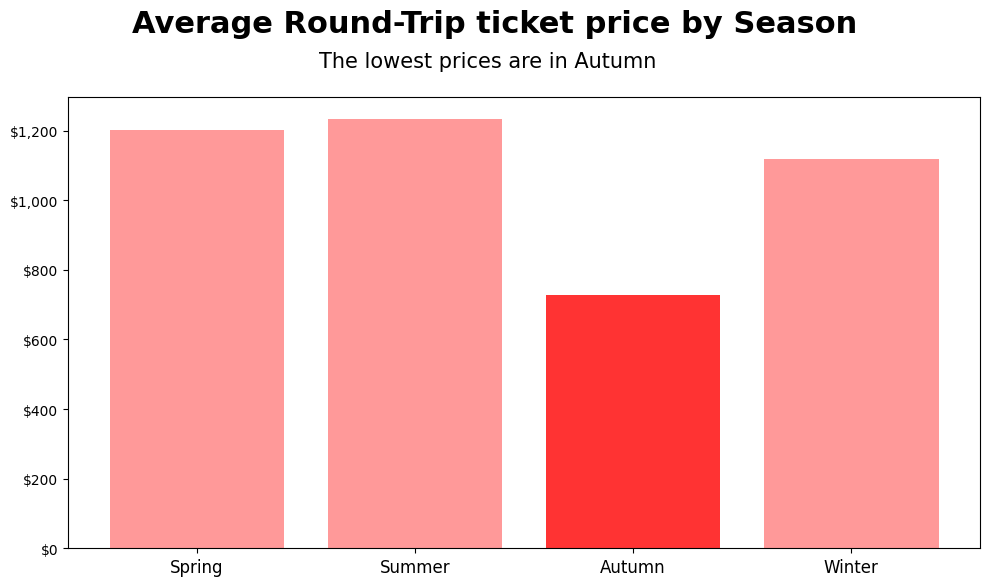

In [32]:
# Calculate average price by season
average_price_by_season = df.groupby('season')['price'].mean().reset_index()
colors= ['#FF9999','#FF9999','#FF3333','#FF9999']
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_price_by_season['season'], average_price_by_season['price'], color = colors)
plt.suptitle('Average Round-Trip ticket price by Season', fontsize=22, y=0.97, fontweight='bold', ha='center')  # Main title
plt.title('The lowest prices are in Autumn           ', fontsize=15, y=1.05, fontweight='regular',  ha='center')  # Subtitle
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))  # Example format
plt.xticks(fontsize = 12)
plt.tight_layout()
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\454389014.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_price_by_season_eco = econom.groupby('season')['price'].mean().reset_index()


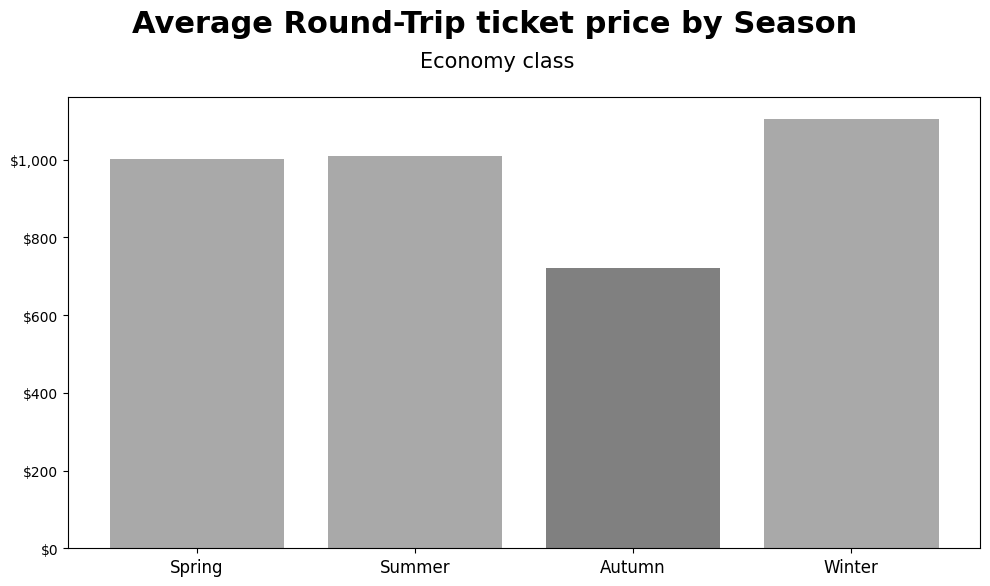

In [33]:
# Calculate average price by season
average_price_by_season_eco = econom.groupby('season')['price'].mean().reset_index()
colors= ['darkgray','darkgray','gray','darkgray']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_price_by_season_eco['season'], average_price_by_season_eco['price'], color = colors)
plt.suptitle('Average Round-Trip ticket price by Season', fontsize=22, y=0.97, fontweight='bold', ha='center')  # Main title
plt.title('Economy class        ', fontsize=15, y=1.05, fontweight='regular',  ha='center')  # Subtitle
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))  # Example format
plt.xticks(fontsize = 12)
plt.tight_layout()
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\1218573533.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_price_by_season_bus = business.groupby('season')['price'].mean().reset_index()


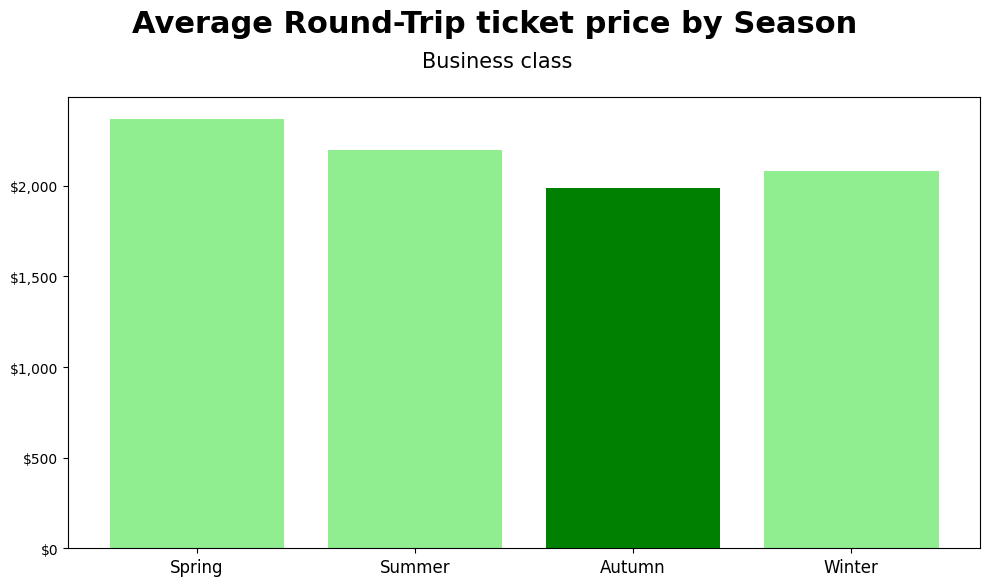

In [34]:
# Calculate average price by season
average_price_by_season_bus = business.groupby('season')['price'].mean().reset_index()
colors= ['lightgreen','lightgreen','green','lightgreen']
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_price_by_season_bus['season'], average_price_by_season_bus['price'], color = colors)
plt.suptitle('Average Round-Trip ticket price by Season', fontsize=22, y=0.97, fontweight='bold', ha='center')  # Main title
plt.title('Business class        ', fontsize=15, y=1.05, fontweight='regular',  ha='center')  # Subtitle
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))  # Example format
plt.xticks(fontsize = 12)
plt.tight_layout()
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\3887589654.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_price_by_month = df.groupby(['month', 'cabin'])['price'].mean().reset_index()


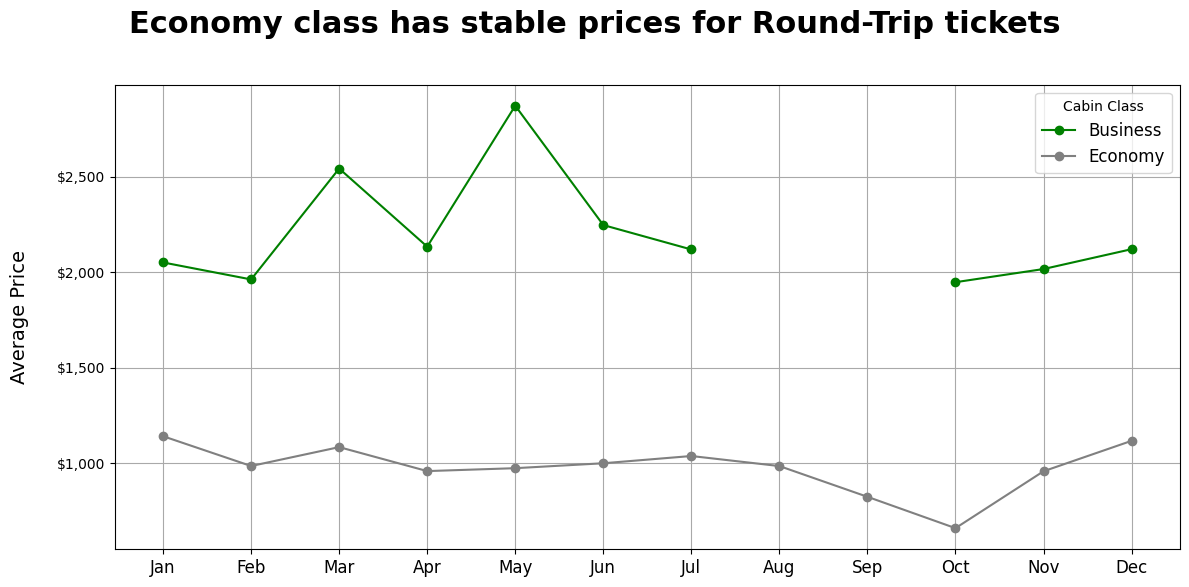

In [35]:
# Calculate average price by month and cabin class
average_price_by_month = df.groupby(['month', 'cabin'])['price'].mean().reset_index()

# Create a line chart
plt.figure(figsize=(12, 6))

# Plotting both cabin classes with specified colors
for cabin in average_price_by_month['cabin'].unique():
    cabin_data = average_price_by_month[average_price_by_month['cabin'] == cabin]
    color = 'green' if cabin == 'Business' else 'gray'  # Set color based on cabin class
    plt.plot(cabin_data['month'], cabin_data['price'], marker='o', label=cabin, color=color)

# Set titles with improved aesthetics
plt.suptitle('Economy class has stable prices for Round-Trip tickets\n', fontsize=22, y=0.97, fontweight='bold', ha='center')  # Main title
# plt.title('Comparative Price Trends for Economy and Business Cabins', fontsize=15, y=1.05, fontweight='regular', ha='center')  # Subtitle

# Formatting
plt.ylabel('Average Price\n', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))  # Format y-axis
plt.xticks(fontsize=12)
plt.legend(title='Cabin Class', fontsize=12)
plt.grid(visible=True,color ='darkgray')  # Optional: Add grid lines for better readability
plt.tight_layout()
plt.show()

#### The line is being closed because there no tickets for Business class in August and September

C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\3535192258.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_arm_econom = arm_econom.groupby('season')['price'].mean().reset_index()
C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\3535192258.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_arm_business = arm_business.groupby('season')['price'].mean().reset_index()


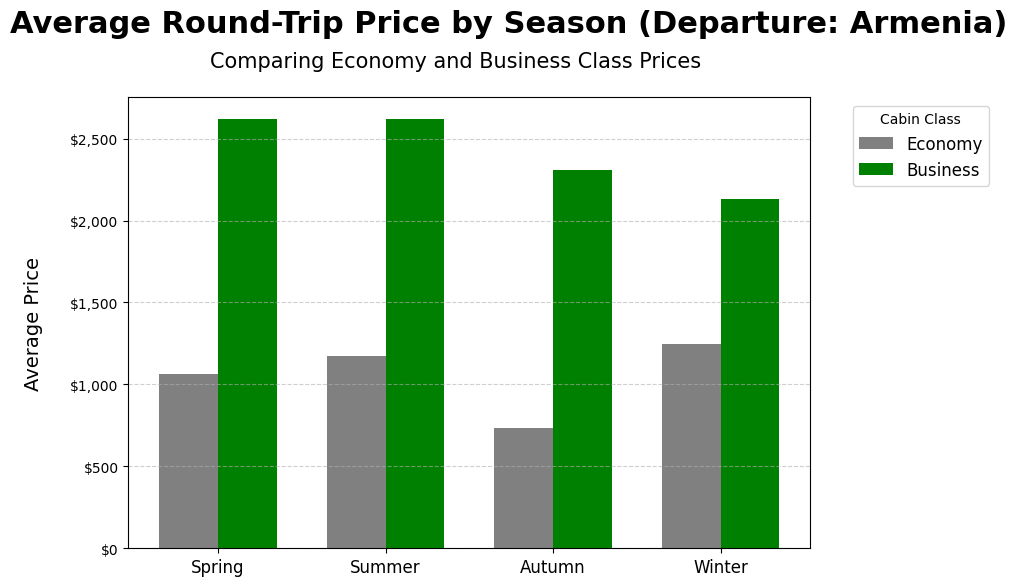

In [36]:
avg_arm_econom = arm_econom.groupby('season')['price'].mean().reset_index()
avg_arm_business = arm_business.groupby('season')['price'].mean().reset_index()

# Merge the two dataframes on 'season'
avg_prices = pd.merge(avg_arm_econom, avg_arm_business, on='season', suffixes=('_economy', '_business'))

# Create a bar chart
plt.figure(figsize=(10, 6))

# Define the positions of the bars
bar_width = 0.35
index = np.arange(len(avg_prices['season']))

# Plot the bars for Economy and Business
plt.bar(index, avg_prices['price_economy'], width=bar_width, label='Economy', color='gray')
plt.bar(index + bar_width, avg_prices['price_business'], width=bar_width, label='Business', color='green')

# Add titles and labels
plt.suptitle('Average Round-Trip Price by Season (Departure: Armenia)', fontsize=22, y=0.97, fontweight='bold', ha='center')
plt.title('Comparing Economy and Business Class Prices    ', fontsize=15, y=1.05, ha='center')
plt.ylabel('Average Price\n', fontsize=14)

# Format the y-axis as currency
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend(title='Cabin Class', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-ticks and labels
plt.xticks(index + bar_width / 2, avg_prices['season'], fontsize=12)

# Add grid lines for better readability
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.6)

# Show plot
plt.tight_layout()
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\2106101575.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sa_econom = sa_econom.groupby('season')['price'].mean().reset_index()
C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\2106101575.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sa_business = sa_business.groupby('season')['price'].mean().reset_index()


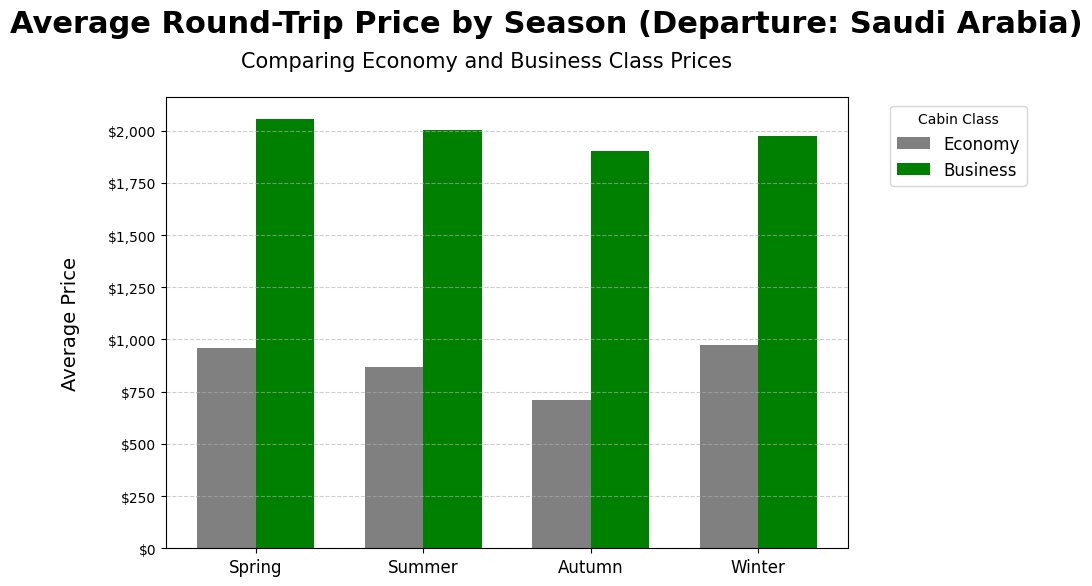

In [37]:
# Group by 'season' and calculate average price for sa_econom and sa_business
avg_sa_econom = sa_econom.groupby('season')['price'].mean().reset_index()
avg_sa_business = sa_business.groupby('season')['price'].mean().reset_index()

# Merge the two dataframes on 'season'
avg_prices_sa = pd.merge(avg_sa_econom, avg_sa_business, on='season', suffixes=('_economy', '_business'))

# Create a bar chart for SA data
plt.figure(figsize=(10, 6))

# Define the positions of the bars
bar_width = 0.35
index = np.arange(len(avg_prices_sa['season']))

# Plot the bars for Economy and Business for SA
plt.bar(index, avg_prices_sa['price_economy'], width=bar_width, label='Economy', color='gray')
plt.bar(index + bar_width, avg_prices_sa['price_business'], width=bar_width, label='Business', color='green')

# Add titles and labels
plt.suptitle('Average Round-Trip Price by Season (Departure: Saudi Arabia)', fontsize=22, y=0.97, fontweight='bold', ha='center')
plt.title('Comparing Economy and Business Class Prices      ', fontsize=15, y=1.05, ha='center')
plt.ylabel('Average Price\n', fontsize=14)

# Format the y-axis as currency
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Set x-ticks and labels
plt.xticks(index + bar_width / 2, avg_prices_sa['season'], fontsize=12)
plt.legend(title='Cabin Class', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
# Add grid lines for better readability
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.6)

# Show plot
plt.tight_layout()
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\793286040.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_month_week = arm_combined.groupby(['month', 'week'])['price'].mean().reset_index()


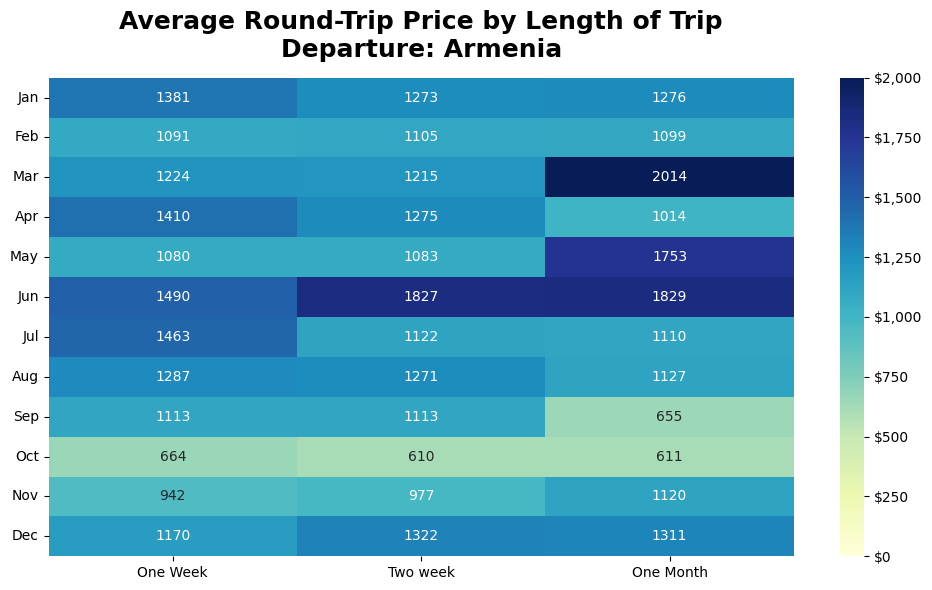

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine arm_econom and arm_business
arm_combined = pd.concat([arm_econom, arm_business])

# Ensure 'month' is ordered correctly from 'Jan' to 'Dec'
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
arm_combined['month'] = pd.Categorical(arm_combined['month'], categories=month_order, ordered=True)

# Group by 'month' and 'week' to calculate the average price
avg_price_by_month_week = arm_combined.groupby(['month', 'week'])['price'].mean().reset_index()

# Pivot the data for easier plotting (for heatmap)
pivot_avg_price = avg_price_by_month_week.pivot(index='month', columns='week', values='price')

# Reorder columns for the x-axis
week_order = ['One Week', 'Two week', 'One Month']
pivot_avg_price = pivot_avg_price[week_order]

# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(pivot_avg_price, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': ''}, vmin=0, vmax=2000)

# Format the color bar ticks as currency
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels([f'${int(x):,}' for x in cbar.get_ticks()])

# Rotate y-axis labels by 90 degrees
plt.yticks(rotation=0)

# Add titles and remove unnecessary labels
plt.title('Average Round-Trip Price by Length of Trip\nDeparture: Armenia', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('')  # Remove the x-axis label
plt.ylabel('')  # Remove the y-axis label

# Adjust the layout for better spacing
plt.tight_layout()

# Show the heatmap
plt.show()


C:\Users\Acer\AppData\Local\Temp\ipykernel_16564\3378389625.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_month_week_sa = sa_combined.groupby(['month', 'week'])['price'].mean().reset_index()


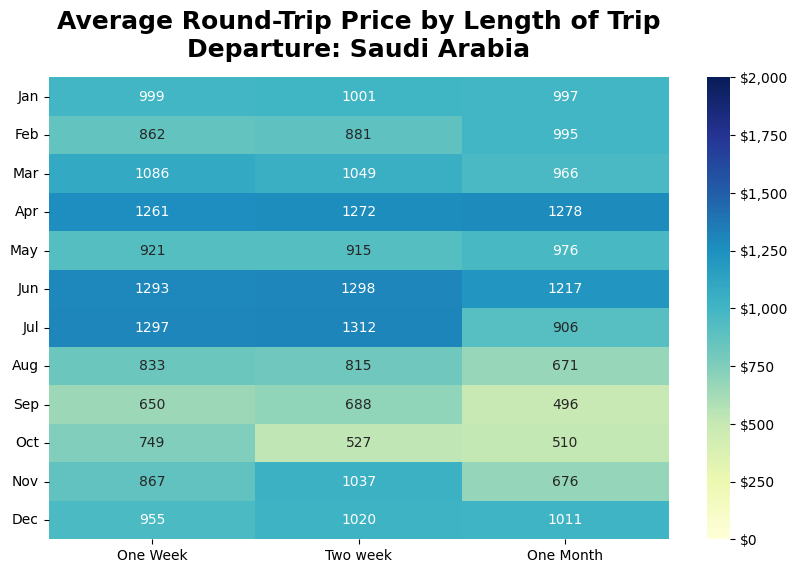

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine sa_econom and sa_business
sa_combined = pd.concat([sa_econom, sa_business])

# Ensure 'month' is ordered correctly from 'Jan' to 'Dec'
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sa_combined['month'] = pd.Categorical(sa_combined['month'], categories=month_order, ordered=True)

# Group by 'month' and 'week' to calculate the average price
avg_price_by_month_week_sa = sa_combined.groupby(['month', 'week'])['price'].mean().reset_index()

# Pivot the data for easier plotting (for heatmap)
pivot_avg_price_sa = avg_price_by_month_week_sa.pivot(index='month', columns='week', values='price')

# Reorder columns for the x-axis
week_order = ['One Week', 'Two week', 'One Month']
pivot_avg_price_sa = pivot_avg_price_sa[week_order]

# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(pivot_avg_price_sa, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': ''}, vmin=0, vmax=2000)

# Format the color bar ticks as currency
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels([f'${int(x):,}' for x in cbar.get_ticks()])

# Rotate y-axis labels by 90 degrees
plt.yticks(rotation=0)

# Add titles and remove unnecessary labels
plt.title('Average Round-Trip Price by Length of Trip\nDeparture: Saudi Arabia', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('')  # Remove the x-axis label
plt.ylabel('')  # Remove the y-axis label

# Rotate y-axis labels
plt.yticks(rotation=0)

plt.show()

### 5.What are the most profitable airlines?

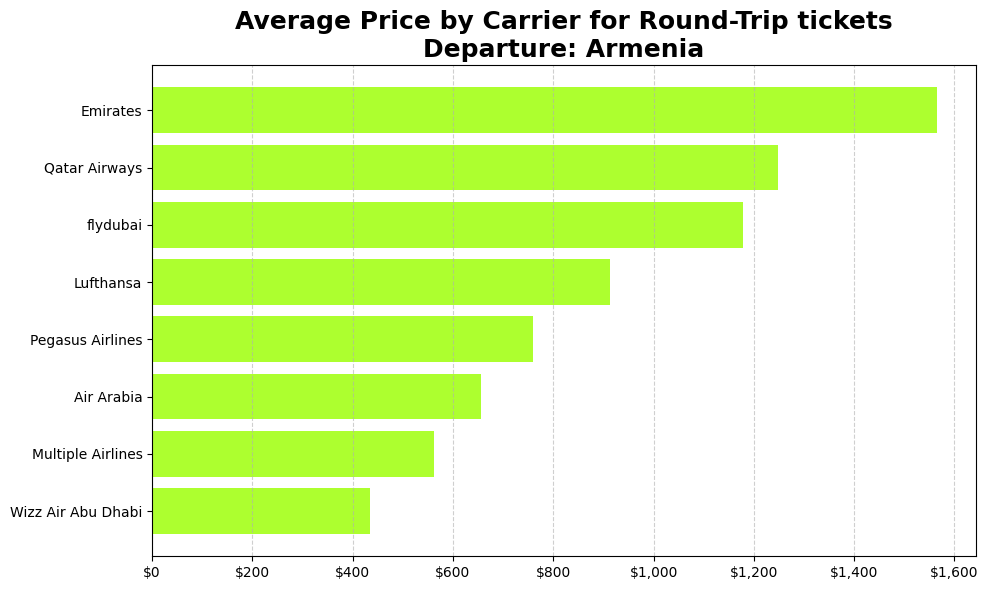

In [49]:
# Filter to include only rows where the carrier matches the returned carrier
armenia = arm_combined[arm_combined["carrier"] == arm_combined["ret_carrier"]]
# Calculate average price by carrier
avg_price_by_carrier_arm = armenia.groupby('carrier')['price'].mean().reset_index()
# Sort the DataFrame by average price in ascending order
avg_price_by_carrier_arm = avg_price_by_carrier_arm.sort_values(by='price')
# Plotting the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(avg_price_by_carrier_arm['carrier'], avg_price_by_carrier_arm['price'], color='greenyellow')
plt.title('Average Price by Carrier for Round-Trip tickets\nDeparture: Armenia', fontsize=18, fontweight='bold')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))  # Format x-axis as currency
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

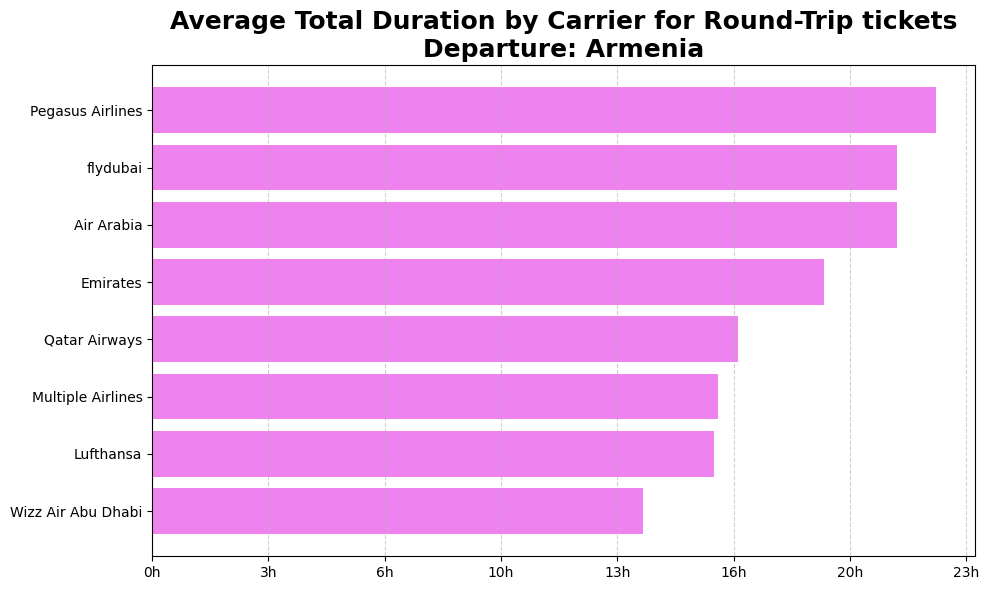

In [50]:
# Filter to include only rows where the carrier matches the returned carrier
armenia = arm_combined[arm_combined["carrier"] == arm_combined["ret_carrier"]]
# Calculate average price by carrier
avg_duration_by_carrier_arm = armenia.groupby('carrier')['duration'].mean().reset_index()
# Sort the DataFrame by average price in ascending order
avg_duration_by_carrier_arm = avg_duration_by_carrier_arm.sort_values(by='duration')
# Plotting the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(avg_duration_by_carrier_arm['carrier'], avg_duration_by_carrier_arm['duration'], color='violet')
plt.title('Average Total Duration by Carrier for Round-Trip tickets\nDeparture: Armenia', fontsize=18, fontweight='bold')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{int(x // 60)}h"))  # Format x-axis as currency
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

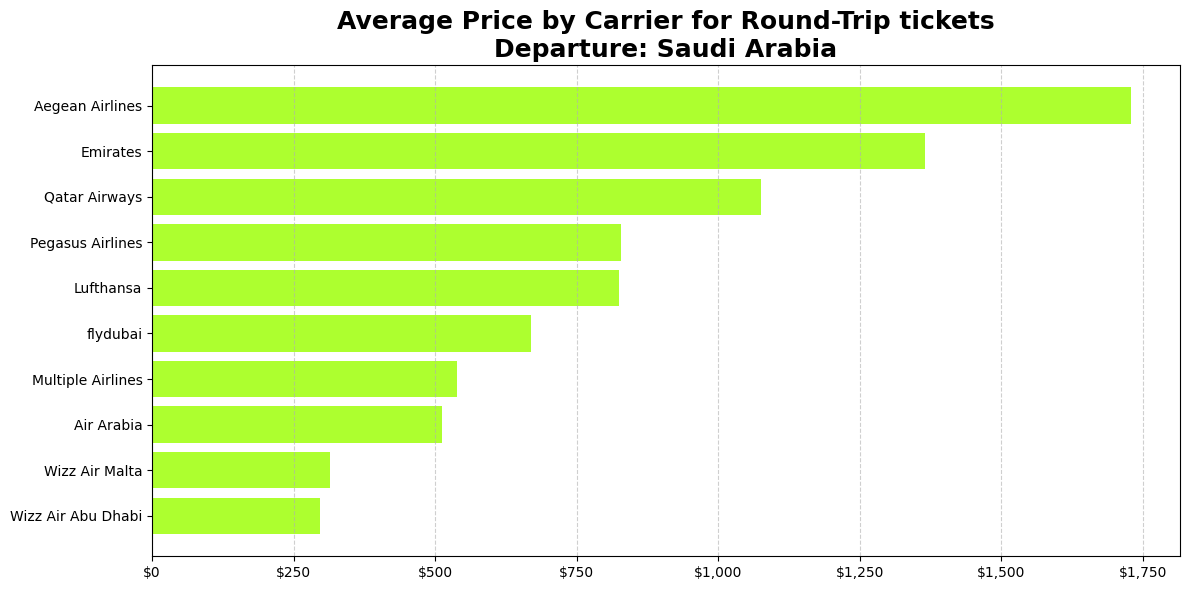

In [51]:
saudi = sa_combined[sa_combined["carrier"] == sa_combined["ret_carrier"]]
avg_price_by_carrier_sa = saudi.groupby('carrier')['price'].mean().reset_index()
avg_price_by_carrier_sa = avg_price_by_carrier_sa.sort_values(by='price')
plt.figure(figsize=(12, 6))
plt.barh(avg_price_by_carrier_sa['carrier'], avg_price_by_carrier_sa['price'], color='greenyellow')
plt.title('Average Price by Carrier for Round-Trip tickets\nDeparture: Saudi Arabia', fontsize=18, fontweight='bold')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))  # Format x-axis as currency
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

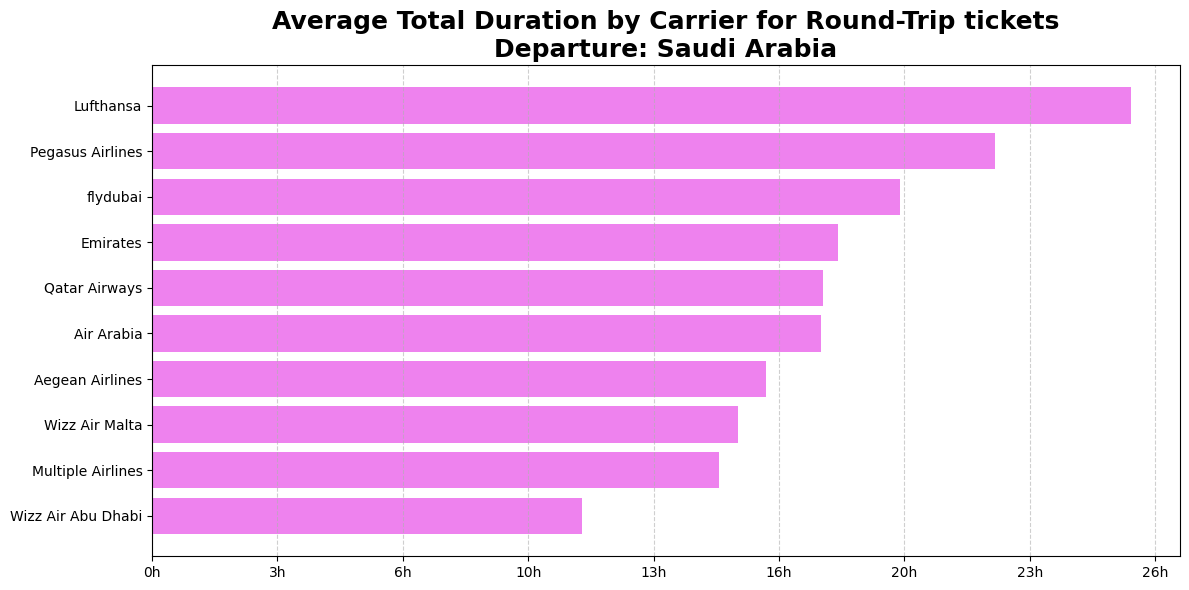

In [52]:
saudi = sa_combined[sa_combined["carrier"] == sa_combined["ret_carrier"]]
avg_dur_by_carrier_sa = saudi.groupby('carrier')['duration'].mean().reset_index()
avg_dur_by_carrier_sa = avg_dur_by_carrier_sa.sort_values(by='duration')
plt.figure(figsize=(12, 6))
plt.barh(avg_dur_by_carrier_sa['carrier'], avg_dur_by_carrier_sa['duration'], color='violet')
plt.title('Average Total Duration by Carrier for Round-Trip tickets\nDeparture: Saudi Arabia', fontsize=18, fontweight='bold')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{int(x // 60)}h"))  # Format x-axis as currency
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### 6.Which airports often have layovers?

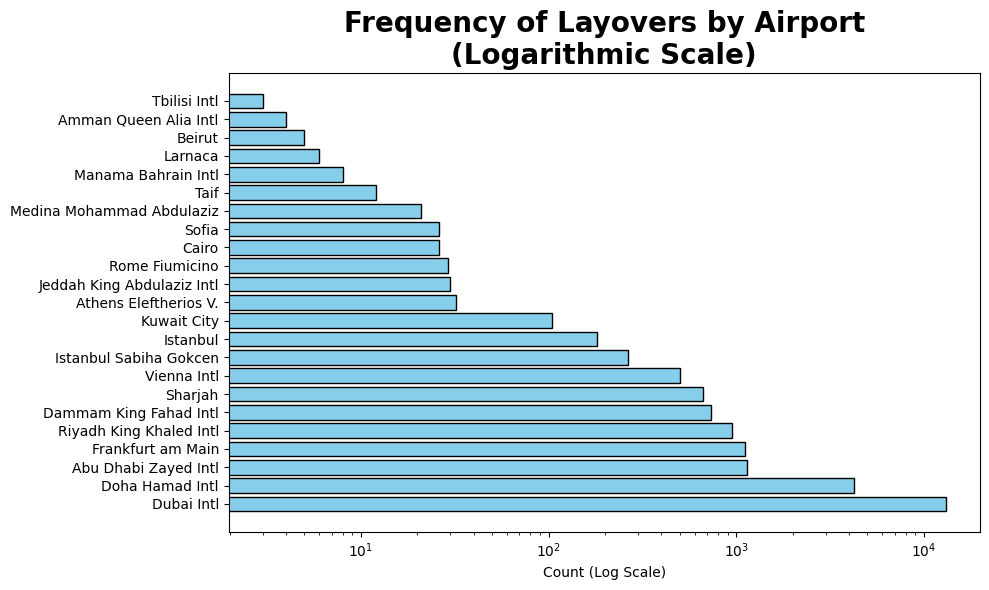

In [80]:
category_counts = df['stop1'].value_counts()

# Plot the horizontal bar chart with a logarithmic X-axis
plt.figure(figsize=(10, 6))
plt.barh(category_counts.index, category_counts.values, color='skyblue', edgecolor='black')
plt.xscale('log')  # Set X-axis to logarithmic scale

# Add titles and labels
plt.title('Frequency of Layovers by Airport\n(Logarithmic Scale)',fontsize = 20, fontweight = "bold")
plt.xlabel('Count (Log Scale)')
# plt.ylabel('Categories')

# Show the plot
plt.tight_layout()  # Avoid clipping the labels
plt.show()

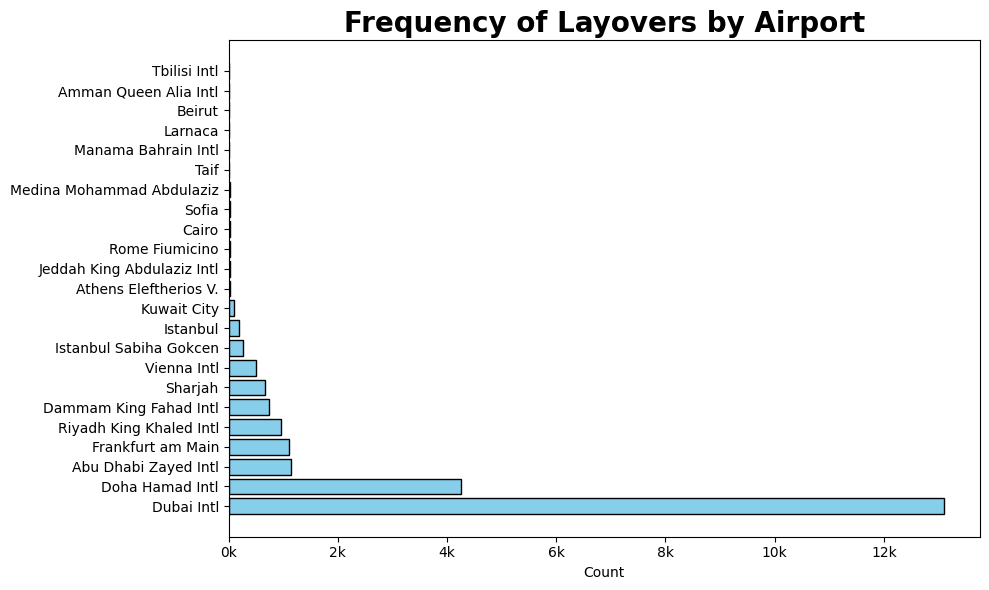

In [79]:
category_counts = df['stop1'].value_counts()

# Plot the horizontal bar chart with a logarithmic X-axis
plt.figure(figsize=(10, 6))
plt.barh(category_counts.index, category_counts.values, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Frequency of Layovers by Airport',fontsize = 20, fontweight = "bold")
plt.xlabel('Count')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{int(x // 1000)}k"))

# Show the plot
plt.tight_layout()  # Avoid clipping the labels
plt.show()